In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_6k_collection)

In [3]:
m1h = load_m1h_activation_data()
tfs = load_annotated_6k_collection()

reading from cache


In [4]:
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)

In [5]:
# TODO move to data_loading.py
df = pd.read_csv("../output/TF-iso_ref-vs-alt.tsv", sep="\t")

In [6]:
df['ref_iso'] = df['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['alt_iso'] = df['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['f_disorder_difference'] = df.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)


def disorder_changes_category(f):
    if pd.isnull(f):
        return np.nan
    elif f == 0:
        return 'fully ordered'
    elif f == 1:
        return 'fully disordered'
    elif f > 0 and f < 1:
        return 'partially disordered'
    else:
        raise ValueError('Invalid fraction')


df['f_disorder_difference_cat'] = df['f_disorder_difference'].apply(disorder_changes_category)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
df['m1h_gte_2_fold_at_least_one_iso_per_gene'] = df['gene_symbol'].map(m1h.groupby('gene')
                                                                    ['gte_2_fold']
                                                                    .any())
df['abs_activation_fold_change_log2'] = df['activation_fold_change_log2'].abs()

In [12]:
dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
dom = dom.loc[dom['category'] == 'effector_domain', :]

In [15]:
# add activation or repression
info = pd.read_excel('../data/external/Soto-et-al_MolCell_2022_Supplementary-tables.xlsx',
                     sheet_name="Table S2")
if info['Effector domain ID'].duplicated().any():
    raise UserWarning('unexpected duplicates')
info = info.set_index('Effector domain ID')
dom['type'] = dom['accession'].map(info['Domain type'])

In [17]:
dom['type'].value_counts()

AD     587
RD     350
Bif     10
Name: type, dtype: int64

In [21]:
dom.groupby('gene')['type'].nunique().value_counts()

1    105
2     32
Name: type, dtype: int64

In [23]:
dom.head()

,gene,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,type
8,PRRX1,PRRX1-2,PRRX1-1,Effector 0583,effector_domain,199,216,17,17,0,0,AD
9,PRRX1,PRRX1-2,PRRX1-3,Effector 0583,effector_domain,199,216,17,17,0,0,AD
10,PRRX1,PRRX1-2,PRRX1-1,Effector 0584,effector_domain,216,245,29,29,0,0,RD
11,PRRX1,PRRX1-2,PRRX1-3,Effector 0584,effector_domain,216,245,29,29,0,0,RD
12,PRRX1,PRRX1-2,PRRX1-1,Effector 0585,effector_domain,44,78,34,0,0,0,AD


In [22]:
df.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,ZBTB18-1,ZBTB18-2,NaN,NaN,True,0.503414
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,PRRX1-2,PRRX1-1,1.000000,fully disordered,True,0.872271
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958,PRRX1-2,PRRX1-3,1.000000,fully disordered,True,0.778958
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,POU2F1-2,POU2F1-1,1.000000,fully disordered,True,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,ATF3-1,ATF3-2,0.166667,partially disordered,False,1.360389


In [27]:
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()

def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)

In [34]:
df.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,ZBTB18-1,ZBTB18-2,NaN,NaN,True,0.503414,NaN,NaN,NaN,NaN,NaN,NaN
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,PRRX1-2,PRRX1-1,1.000000,fully disordered,True,0.872271,0.333333,0.0,1.0,0.0,NaN,NaN
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958,PRRX1-2,PRRX1-3,1.000000,fully disordered,True,0.778958,0.333333,0.0,1.0,0.0,NaN,NaN
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,POU2F1-2,POU2F1-1,1.000000,fully disordered,True,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,ATF3-1,ATF3-2,0.166667,partially disordered,False,1.360389,0.000000,0.0,0.0,0.0,NaN,NaN


In [35]:
(df.loc[df['activation_fold_change_log2'].notnull(),
        ['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed']]
    .notnull()
    .groupby(['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed'])
    .size())

fraction_of_AD_domains_removed  fraction_of_RD_domains_removed  fraction_of_Bif_domains_removed
False                           False                           False                              175
                                                                True                                 2
                                True                            False                               38
                                                                True                                 1
True                            False                           False                               66
                                                                True                                 3
                                True                            False                               42
dtype: int64

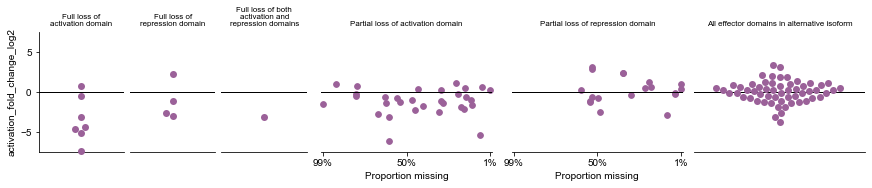

In [69]:
# seperately for repression and activation?
# full loss of activation domain
# full loss of repression domain
# partial loss of each
# loss of both?

from matplotlib import pyplot as plt
COLOR_PURPLE = (155 / 255, 97 / 255, 153 / 255)


df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]

fig, axs = plt.subplots(1, 6, sharey=True, width_ratios=[1, 1, 1, 2, 2, 2])
fig.set_size_inches(w=12, h=2.5)

point_size = 7

axs[0].set_title('Full loss of\nactivation domain',
fontsize=8)
sns.swarmplot(data=df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0))
                           ,
                           :],
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              color=COLOR_PURPLE,
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')

axs[1].set_title('Full loss of\nrepression domain',
fontsize=8)
sns.swarmplot(data=df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0))

                          , :],
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              color=COLOR_PURPLE,
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')



axs[2].set_title('Full loss of both\nactivation and\nrepression domains',
fontsize=8)
sns.swarmplot(data=df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :],
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[2],
              color=COLOR_PURPLE,
              alpha=1)
axs[2].set_xticks([])
axs[2].set_xlabel('')



axs[3].set_title('Partial loss of activation domain',
fontsize=8)
partial_loss = (df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)))
axs[3].scatter(df.loc[partial_loss, 'fraction_of_AD_domains_removed'].values,
               df.loc[partial_loss, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[3].set_xlabel('Proportion missing')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])
#axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[4].set_title('Partial loss of repression domain',
fontsize=8)
partial_loss = (df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)))

axs[4].scatter(df.loc[partial_loss, 'fraction_of_RD_domains_removed'].values,
               df.loc[partial_loss, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[4].set_xlabel('Proportion missing')
axs[4].set_xlim(1, 0)
axs[4].set_xticks([0.99, 0.5, 0.01])
axs[4].set_xticklabels([f'{x:.0%}' for x in axs[4].get_xticks()])
#axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[5].set_title('All effector domains in alternative isoform',
fontsize=8)
sns.swarmplot(data=df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :],
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              color=COLOR_PURPLE,
              alpha=1)
axs[5].set_xticks([])
axs[5].set_xlabel('')


"""


axs[2].set_title('Full domain in\nalternative isoform', fontsize=10)
axs[2].scatter(data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'domain_n_aa_to_change'].values,
               data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'Y2H_result_mean'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[2].set_xlabel('Distance of alternative\nsequence from domain\n(number of AA)')

for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks(np.linspace(0, 1, 21), minor=True)
axs[0].set_yticklabels(['{:.0%}'.format(y) for y in axs[0].get_yticks()])
axs[0].set_ylabel('Fraction of domain-domain mediated\nPPIs with alternative isoform')
"""
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
fig.savefig('../figures/activation_vs_domain_removal.pdf', bbox_inches='tight')

<AxesSubplot: xlabel='f_disorder_difference', ylabel='activation_fold_change_log2'>

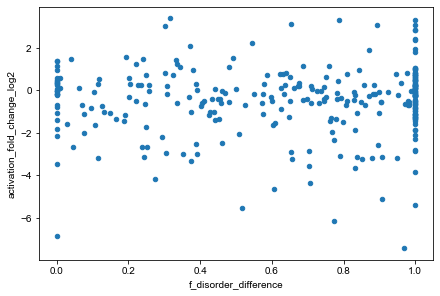

In [7]:
df.plot.scatter(x='f_disorder_difference', y='activation_fold_change_log2')

In [22]:
x_var = 'f_disorder_difference'
y_var = 'activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.034445070028619504, 0.5476782424869322)
SpearmanrResult(correlation=0.04381332252514251, pvalue=0.4443267814950931)


In [33]:
x_var = 'f_disorder_difference'
y_var = 'abs_activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(-0.01326449479277789, 0.8169459410613703)
SpearmanrResult(correlation=-0.03272960073615822, pvalue=0.5678080563859396)


<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='activation_fold_change_log2'>

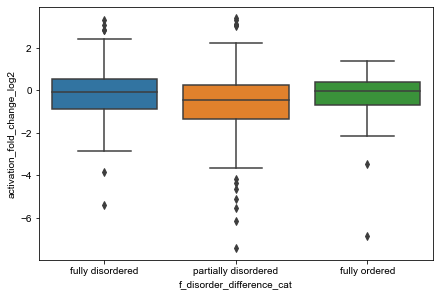

In [30]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='activation_fold_change_log2')

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='abs_activation_fold_change_log2'>

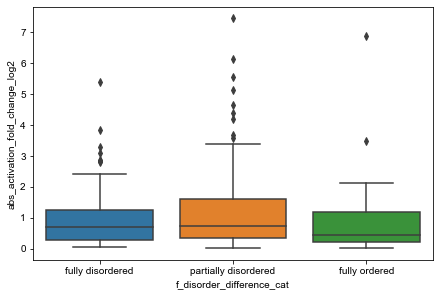

In [32]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='abs_activation_fold_change_log2')

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='abs_activation_fold_change_log2'>

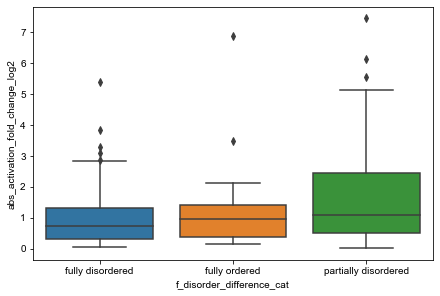

In [39]:
sns.boxplot(data=df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True), :],
            x='f_disorder_difference_cat',
            y='abs_activation_fold_change_log2')

In [40]:
stats.mannwhitneyu(
        df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully ordered'),
               'abs_activation_fold_change_log2'].values,
               df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully disordered')
               , 'abs_activation_fold_change_log2'].values
                          )

MannwhitneyuResult(statistic=1351.0, pvalue=0.41985831027113873)

Interestingly, I don't see a difference between disordered and ordered changes and 
activation levels. Check for confounding factors like the size of the changes.

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='aa_seq_pct_id'>

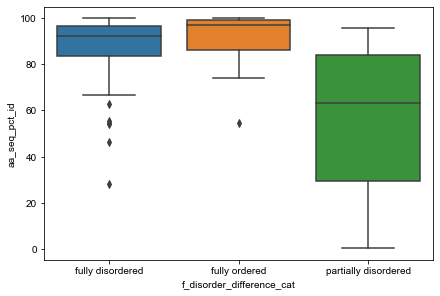

In [49]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='aa_seq_pct_id', 
            order=['fully disordered',
                   'fully ordered',
                   'partially disordered'])

<AxesSubplot: xlabel='f_disorder_difference', ylabel='abs_activation_fold_change_log2'>

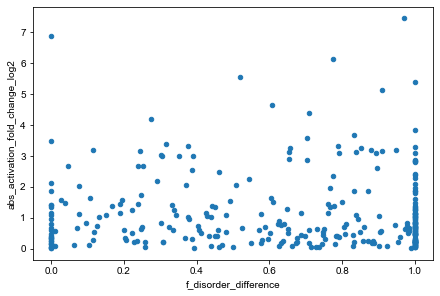

In [34]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [ ]:
# x axis as size of change (or aa %id), y axis as act diff, split by dis and ordered

In [50]:
# check examples
(df.loc[df['f_disorder_difference_cat'] == 'fully ordered',
         :]
         .sort_values('abs_activation_fold_change_log2',
                      ascending=False)).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,abs_activation_fold_change_log2,m1h_gte_2_fold_at_least_one_iso_per_gene
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,True,186,163,6,5,False,True,False,True,False,False,False,False,2.0,12.121212,True,86.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,7.110312,0.246030,-6.864281,TBPL1-1,TBPL1-2,0.0,fully ordered,6.864281,True
224,E2F8,ENSG00000129173,E2F,True,E2F8|1/4|03G03,E2F8|2/4|03A06,ENST00000250024|ENST00000527884|ENST00000620009,NaN,False,True,True,867,842,12,12,False,False,False,False,True,False,False,False,1.0,16.774194,True,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.318486,-0.146185,-3.464671,E2F8-1,E2F8-2,0.0,fully ordered,3.464671,True
332,MLX,ENSG00000108788,bHLH,True,MLX|1/4|11G02,MLX|2/4|01D12,ENST00000435881,NaN,False,True,True,244,240,8,8,False,True,False,True,False,False,False,False,0.0,0.000000,False,88.8,2.0,0.0,2.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.774919,-0.354498,-2.129417,MLX-1,MLX-2,0.0,fully ordered,2.129417,True
11,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|3/5|02E09,ENST00000403491,ENST00000407417,False,False,True,509,501,11,11,True,False,False,False,False,False,False,False,0.0,0.000000,False,98.2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.185884,2.340298,-1.845586,NFIA-2,NFIA-3,0.0,fully ordered,1.845586,True
260,TFCP2,ENSG00000135457,Grainyhead,True,TFCP2|1/3|03E08,TFCP2|2/3|03H07,ENST00000257915,NaN,False,True,True,502,451,15,14,False,False,True,False,False,True,False,False,0.0,23.502304,True,89.8,12.0,0.0,12.0,12.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.867457,1.466333,-1.401124,TFCP2-1,TFCP2-2,0.0,fully ordered,1.401124,True


In [52]:
df['f_disorder_difference_cat'].value_counts()

partially disordered    250
fully disordered        135
fully ordered            36
Name: f_disorder_difference_cat, dtype: int64

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='PPI_jaccard'>

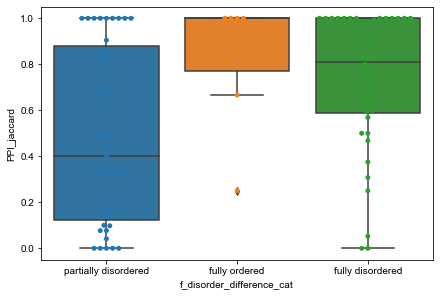

In [72]:
# TODO move PPI stuff to different notebook
sns.swarmplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')
sns.boxplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')

In [71]:
x = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully ordered'),
       'PPI_jaccard'].values
y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully disordered'),
       'PPI_jaccard'].values
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=106.0, pvalue=0.152530111415017)

<AxesSubplot: xlabel='f_disorder_difference', ylabel='PPI_jaccard'>

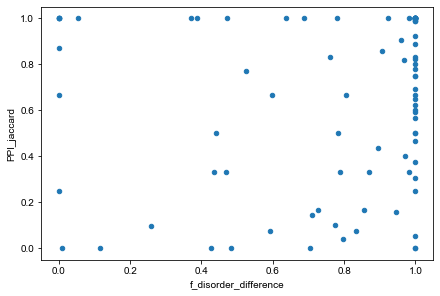

In [57]:
(df.loc[(df['n_positive_PPI_ref'] > 0) & 
        (df['n_positive_PPI_alt'] > 0), 
        :].plot.scatter(x='f_disorder_difference', y='PPI_jaccard'))

In [58]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.09815410623254812, 0.36860060983813053)
SpearmanrResult(correlation=0.15007663064303997, pvalue=0.16782909620037645)


In [59]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              (df['f_disorder_difference'] > 0) &
              (df['f_disorder_difference'] < 1) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.12716444000927726, 0.4404440335565583)
SpearmanrResult(correlation=0.15799696005755584, pvalue=0.33673312771944086)


In [62]:
df.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,abs_activation_fold_change_log2,m1h_gte_2_fold_at_least_one_iso_per_gene
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,ZBTB18-1,ZBTB18-2,NaN,NaN,0.503414,True
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,PRRX1-2,PRRX1-1,1.000000,fully disordered,0.872271,True
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958,PRRX1-2,PRRX1-3,1.000000,fully disordered,0.778958,True
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,POU2F1-2,POU2F1-1,1.000000,fully disordered,NaN,True
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,ATF3-1,ATF3-2,0.166667,partially disordered,1.360389,False


In [8]:
# TODO move
from data_loading import load_tf_families, load_human_tf_db, load_y2h_isoform_data

y2h = load_y2h_isoform_data()
tfdb = load_human_tf_db()
y2h["is_tf_tf_ppi"] = y2h["db_gene_symbol"].isin(tfdb["HGNC symbol"].unique())

# of reference dimer PPI, are all lost, some lost, none lost
def ppi_pertubation(row, ppi):
    ref_clone_acc = row["clone_acc_ref"]
    alt_clone_acc = row["clone_acc_alt"]
    if (
        ref_clone_acc not in ppi["ad_clone_acc"].unique()
        or alt_clone_acc not in ppi["ad_clone_acc"].unique()
    ):
        return np.nan
    df = (
        ppi.loc[
            ppi["ad_clone_acc"].isin([ref_clone_acc, alt_clone_acc]),
            ["ad_clone_acc", "db_gene_symbol", "Y2H_result"],
        ]
        .pivot(values="Y2H_result", index="db_gene_symbol", columns="ad_clone_acc")
        .dropna()
    )
    df = df.loc[df.any(axis=1), :]
    if df.shape[0] == 0:
        return np.nan
    if df.all().all():
        return "retains all"
    elif not df[alt_clone_acc].any():
        return "loses all"
    elif df[alt_clone_acc].sum() > df[ref_clone_acc].sum():
        return "gains some"
    else:
        return "loses some"


df["other_than_tf_tf_ppi"] = df.apply(
    ppi_pertubation, ppi=y2h.loc[~y2h["is_tf_tf_ppi"], :], axis=1
)

In [9]:
# add other-than-tf category
def tf_tf_vs_other_ppi_cat(row):
    if (pd.isnull(row['n_positive_PPI_ref']) or
        pd.isnull(row['n_positive_PPI_alt']) or
        (row['n_positive_PPI_ref'] == 0) or
        (row['n_positive_PPI_alt'] == 0) or
        pd.isnull(row['tf_tf_ppi'])  or
        pd.isnull(row['other_than_tf_tf_ppi'])
        ):
       return np.nan
    elif row['tf_tf_ppi'] == 'retains all':
        if row['other_than_tf_tf_ppi'] == 'retains all':
            return 'No PPI change'
        else:
            return 'non-TF-TF PPI change'
    else:
        if row['other_than_tf_tf_ppi'] == 'retains all':
            return 'TF-TF PPI change'
        else:
            return 'TF-TF and other PPIs change'
    

df['tf_tf_vs_other_ppi_cat'] = df.apply(tf_tf_vs_other_ppi_cat, axis=1)

In [64]:
def tf_dimer_vs_other_ppi_cat(row):
    if (pd.isnull(row['n_positive_PPI_ref']) or
        pd.isnull(row['n_positive_PPI_alt']) or
        (row['n_positive_PPI_ref'] == 0) or
        (row['n_positive_PPI_alt'] == 0) or
        pd.isnull(row['dimer_ppi'])  or
        pd.isnull(row['other_than_dimer_ppi'])
        ):
       return np.nan
    elif row['dimer_ppi'] == 'retains all':
        if row['other_than_dimer_ppi'] == 'retains all':
            return 'No PPI change'
        else:
            return 'non-dimerizing PPI change'
    else:
        if row['other_than_dimer_ppi'] == 'retains all':
            return 'dimer PPI change'
        else:
            return 'dimer and other PPIs change'
    

df['dimer_vs_other_ppi_cat'] = df.apply(tf_dimer_vs_other_ppi_cat, axis=1)

Text(0.5, 0, '')

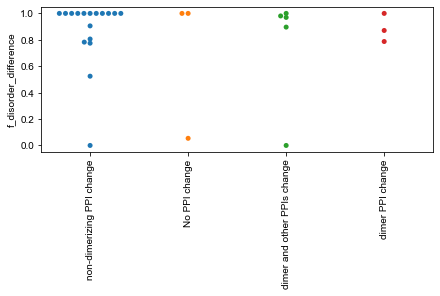

In [77]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df, x='dimer_vs_other_ppi_cat', y='f_disorder_difference', ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

Text(0.5, 0, '')

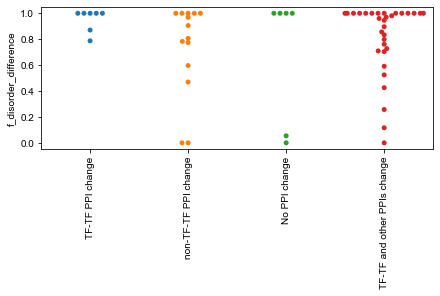

In [10]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df, x='tf_tf_vs_other_ppi_cat', y='f_disorder_difference', ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

In [11]:
df

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,ZBTB18-1,ZBTB18-2,NaN,NaN,True,0.503414
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,PRRX1-2,PRRX1-1,1.000000,fully disordered,True,0.872271
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958,PRRX1-2,PRRX1-3,1.000000,fully disordered,True,0.778958
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN,POU2F1-2,POU2F1-1,1.000000,fully disordered,True,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389,ATF3-1,ATF3-2,0.166667,partially disordered,False,1.360389


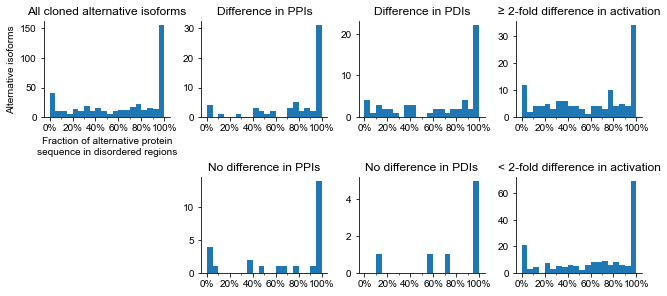

In [27]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(w=9, h=4)
n_bins=20
axs[0, 0].hist(df['f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 0].set_title('All cloned alternative isoforms')

axs[0, 1].hist(df.loc[(df['PPI_jaccard'] < 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 1].set_title('Difference in PPIs')


axs[1, 1].hist(df.loc[(df['PPI_jaccard'] == 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[1, 1].set_title('No difference in PPIs')


axs[0, 2].hist(df.loc[(df['PDI_jaccard'] < 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 2].set_title('Difference in PDIs')

axs[1, 2].hist(df.loc[(df['PDI_jaccard'] == 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[1, 2].set_title('No difference in PDIs')

axs[0, 3].hist(df.loc[(df['abs_activation_fold_change_log2'] >= 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 3].set_title('≥ 2-fold difference in activation')

axs[1, 3].hist(df.loc[(df['abs_activation_fold_change_log2'] < 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[1, 3].set_title('< 2-fold difference in activation')

for ax in axs.flatten():
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_xticks(np.linspace(0, 1, 11), minor=True)
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])    

axs[1, 0].axis('off')
axs[0, 0].set_ylabel('Alternative isoforms')
axs[0, 0].set_xlabel('Fraction of alternative protein\nsequence in disordered regions')
fig.savefig('../figures/disorder-pct-of-changes-vs-assay-differences_hist.pdf', bbox_inches='tight')

In [6]:
# monkeypatch from https://github.com/mwaskom/seaborn/issues/525
fit_kde_func = sns.categorical._ViolinPlotter.fit_kde

def reflected_once_kde(self, x, bw):
    lb=0
    ub=1

    kde, bw_used = fit_kde_func(self, x, bw)

    kde_evaluate = kde.evaluate

    def truncated_kde_evaluate(x):
        val = np.where((x>=lb)&(x<=ub), kde_evaluate(x), 0)
        val += np.where((x>=lb)&(x<=ub), kde_evaluate(lb-x), 0)
        val += np.where((x>lb)&(x<=ub), kde_evaluate(ub-(x-ub)), 0)
        return val

    kde.evaluate = truncated_kde_evaluate
    return kde, bw_used

sns.categorical._ViolinPlotter.fit_kde = reflected_once_kde

<AxesSubplot: >

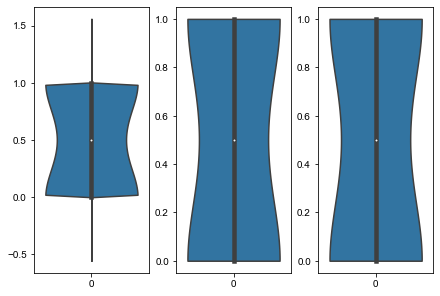

In [8]:
# TEST violin plot on bounded data
fig, axs = plt.subplots(1, 3)
data = [0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1]
sns.violinplot(data=data,
               ax=axs[0])
sns.violinplot(data=data,
               ax=axs[1],
               cut=0)
sns.violinplot(data=data,
               ax=axs[2],
               cut=0)

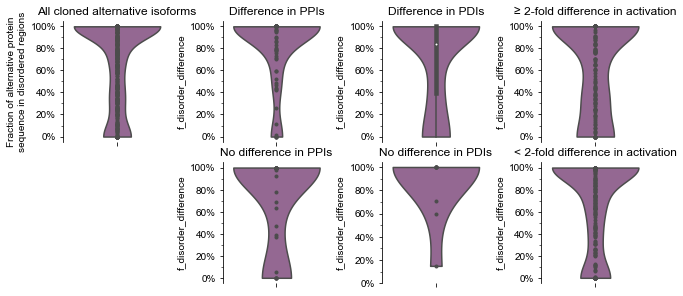

In [16]:
# add violin plot
from plotting import COLOR_PURPLE

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(w=9, h=4)
n_bins=20
sns.violinplot(data=df,
              y='f_disorder_difference',
                     inner='point',
       color=COLOR_PURPLE,
              ax=axs[0, 0],
              clip_on=False,
               cut=0,
             alpha=0.5  # TMP - to check no overlap
              )
axs[0, 0].set_title('All cloned alternative isoforms')

sns.violinplot(data=df.loc[(df['PPI_jaccard'] < 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
                   :],
              y='f_disorder_difference',
                  inner='point',
          color=COLOR_PURPLE,
              ax=axs[0, 1],
              clip_on=False,
               cut=0,
            alpha=0.5  # TMP - to check no overlap
              )
axs[0, 1].set_title('Difference in PPIs')

sns.violinplot(data=df.loc[(df['PPI_jaccard'] == 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
                   :],
              y='f_disorder_difference',
               inner='point',
             color=COLOR_PURPLE,
              ax=axs[1, 1],
              clip_on=False,
              cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[1, 1].set_title('No difference in PPIs')

sns.violinplot(data=df.loc[(df['PDI_jaccard'] < 1), :],
              y='f_disorder_difference',
              color=COLOR_PURPLE,
              ax=axs[0, 2],
              clip_on=False,
                cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[0, 2].set_title('Difference in PDIs')

sns.violinplot(data=df.loc[(df['PDI_jaccard'] == 1), :],
              y='f_disorder_difference',
              inner='point',
              color=COLOR_PURPLE,
              ax=axs[1, 2],
              clip_on=False,
            cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[1, 2].set_title('No difference in PDIs')

sns.violinplot(data=df.loc[(df['abs_activation_fold_change_log2'] >= 1), :],
              y='f_disorder_difference',
               inner='point',
             color=COLOR_PURPLE,
              ax=axs[0, 3],
              clip_on=False,  
            cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[0, 3].set_title('≥ 2-fold difference in activation')


#sns.stripplot(data=df.loc[(df['abs_activation_fold_change_log2'] < 1), :],
#              y='f_disorder_difference',
#              color='black',
#              ax=axs[1, 3],
#              clip_on=False,
#              alpha=0.5  # TMP - to check no overlap
#              )
sns.violinplot(data=df.loc[(df['abs_activation_fold_change_log2'] < 1), :],
              y='f_disorder_difference',
              inner='point',
              color=COLOR_PURPLE,
              ax=axs[1, 3],
              clip_on=False,
              cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[1, 3].set_title('< 2-fold difference in activation')

for ax in axs.flatten():
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticks(np.linspace(0, 1, 11), minor=True)
    ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])    

axs[1, 0].axis('off')
axs[0, 0].set_ylabel('Fraction of alternative protein\nsequence in disordered regions')
fig.savefig('../figures/disorder-pct-of-changes-vs-assay-differences_violin.pdf', bbox_inches='tight')

In [4]:
# get genes with KRAB domains
KRAB_PFAM_AC = 'PF01352'
df = pd.concat([g.aa_feature_disruption(g.orfs[0].name) for g in tfs.values()])

In [5]:
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length
0,ZBTB18,ZBTB18-1,ZBTB18-2,PF00651,0,0,0,108
1,ZBTB18,ZBTB18-1,ZBTB18-2,PF13894,9,0,0,21
2,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_5,0,0,0,125
3,ZBTB18,ZBTB18-1,ZBTB18-2,PF13894_flank_C,0,0,0,15
4,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_5_flank_N,0,0,0,15


In [6]:
df = df.loc[df['accession'] == KRAB_PFAM_AC, :]
df = df.groupby(['gene', 'ref_iso', 'alt_iso', 'accession']).sum().reset_index()

In [7]:
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length
0,ZFP1,ZFP1-1,ZFP1-2,PF01352,27,0,0,41
1,ZFP1,ZFP1-1,ZFP1-3,PF01352,0,0,0,41
2,ZFP1,ZFP1-1,ZFP1-4,PF01352,41,0,0,41
3,ZKSCAN1,ZKSCAN1-1,ZKSCAN1-2,PF01352,0,0,0,41
4,ZKSCAN3,ZKSCAN3-1,ZKSCAN3-2,PF01352,0,0,0,41


In [8]:
print(df['gene'].nunique(), 'TF genes with KRAB domains in TFiso1.0')

43 TF genes with KRAB domains in TFiso1.0


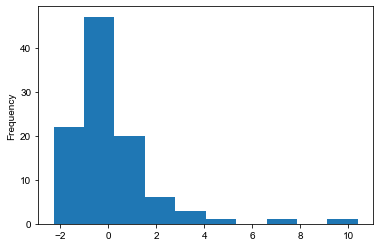

In [9]:
m1h.loc[m1h['gene'].isin(df['gene'].unique()), 'mean'].plot.hist()

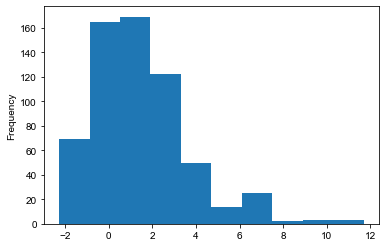

In [10]:
m1h.loc[:, 'mean'].plot.hist()

In [11]:
df.columns

Index(['gene', 'ref_iso', 'alt_iso', 'accession', 'deletion', 'insertion',
       'frameshift', 'length'],
      dtype='object')

In [12]:
df['is_affected'] = df[['deletion', 'insertion', 'frameshift']].sum(axis=1) > 0
df['complete_removal'] = (df['deletion'] == df['length'])

In [13]:
df['is_affected'].value_counts()

False    41
True     33
Name: is_affected, dtype: int64

In [14]:
df['complete_removal'].value_counts()

False    67
True      7
Name: complete_removal, dtype: int64

In [15]:
m1h['iso_acc'] = m1h['clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [16]:
df['m1h_ref'] = df['ref_iso'].map(m1h.set_index('iso_acc')['mean'])
df['m1h_alt'] = df['alt_iso'].map(m1h.set_index('iso_acc')['mean'])

In [17]:
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length,is_affected,complete_removal,m1h_ref,m1h_alt
0,ZFP1,ZFP1-1,ZFP1-2,PF01352,27,0,0,41,True,False,-2.005591,-0.617791
1,ZFP1,ZFP1-1,ZFP1-3,PF01352,0,0,0,41,False,False,-2.005591,0.077712
2,ZFP1,ZFP1-1,ZFP1-4,PF01352,41,0,0,41,True,True,-2.005591,0.339418
3,ZKSCAN1,ZKSCAN1-1,ZKSCAN1-2,PF01352,0,0,0,41,False,False,0.211933,-0.912573
4,ZKSCAN3,ZKSCAN3-1,ZKSCAN3-2,PF01352,0,0,0,41,False,False,1.062538,1.571580


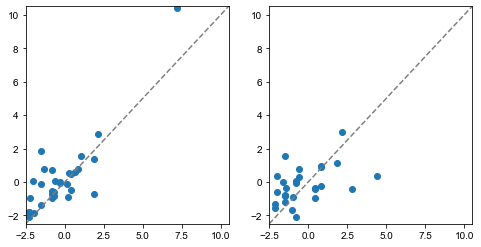

In [18]:
# scatter
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
axs[0].scatter(df.loc[~df['is_affected'], 'm1h_ref'].values,
               df.loc[~df['is_affected'], 'm1h_alt'].values)
axs[1].scatter(df.loc[df['is_affected'], 'm1h_ref'].values,
               df.loc[df['is_affected'], 'm1h_alt'].values)
for ax in axs:
    low, high = -2.5, 10.5
    ax.set_xlim(low, high)
    ax.set_ylim(low, high)
    ax.plot([low, high], [low, high], linestyle='--', color='grey')

MannwhitneyuResult(statistic=412.0, pvalue=0.46274107024193056)


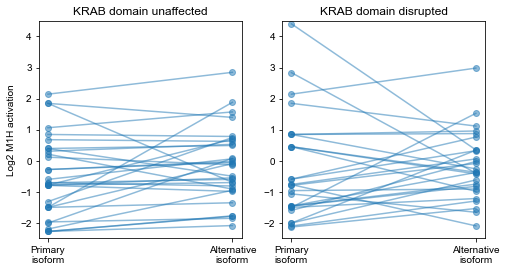

In [19]:
def pair_plot(df):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    for _i, row in df.iterrows():
        axs[int(row['is_affected'])].plot(
            [0, 1], 
            [row['m1h_ref'], row['m1h_alt']],
            'o-',
            color='C0', alpha=0.5)
    for ax in axs:
        ax.set_ylim(-2.5, 4.5)  # NOTE: this cuts off a datapoint
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Primary\nisoform', 'Alternative\nisoform'])
    axs[0].set_ylabel('Log2 M1H activation')
    axs[0].set_title('KRAB domain unaffected')
    axs[1].set_title('KRAB domain disrupted')
    a = (df.loc[~df['is_affected'], 'm1h_ref'] - df.loc[~df['is_affected'], 'm1h_alt']).values
    b = (df.loc[df['is_affected'], 'm1h_ref'] - df.loc[df['is_affected'], 'm1h_alt']).values
    print(stats.mannwhitneyu(a, b))


pair_plot(df.dropna())
plt.savefig('../figures/KRAB-affected-M1H_pairplot.pdf',
            bbox_inches='tight')

In [24]:
tfs['ATF2'].orfs[1].name

'ATF2-2'

In [117]:
dbd_to_plot

Index(['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'HMG/Sox', 'bZIP',
       'Ets', 'SMAD', 'Forkhead'],
      dtype='object')

In [29]:
from data_loading import load_tf_families
df = pd.DataFrame([(tf_name, tf.orfs[0].name, alt_iso.name) for tf_name, tf in tfs.items() for alt_iso in tf.orfs[1:]],
                    columns=['gene', 'ref_iso', 'alt_iso'])
tf_fam = load_tf_families()
df['DBD'] = df['gene'].map(tf_fam)
df['m1h_ref'] = df['ref_iso'].map(m1h.set_index('iso_acc')['mean'])
df['m1h_alt'] = df['alt_iso'].map(m1h.set_index('iso_acc')['mean'])

,gene,ref_iso,alt_iso,DBD
0,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2 ZF
1,PRRX1,PRRX1-1,PRRX1-2,Homeodomain
2,PRRX1,PRRX1-1,PRRX1-3,Homeodomain
3,POU2F1,POU2F1-1,POU2F1-2,Homeodomain; POU
4,ATF3,ATF3-1,ATF3-2,bZIP


In [42]:
len(dbd_to_plot) ** 0.5

3.0

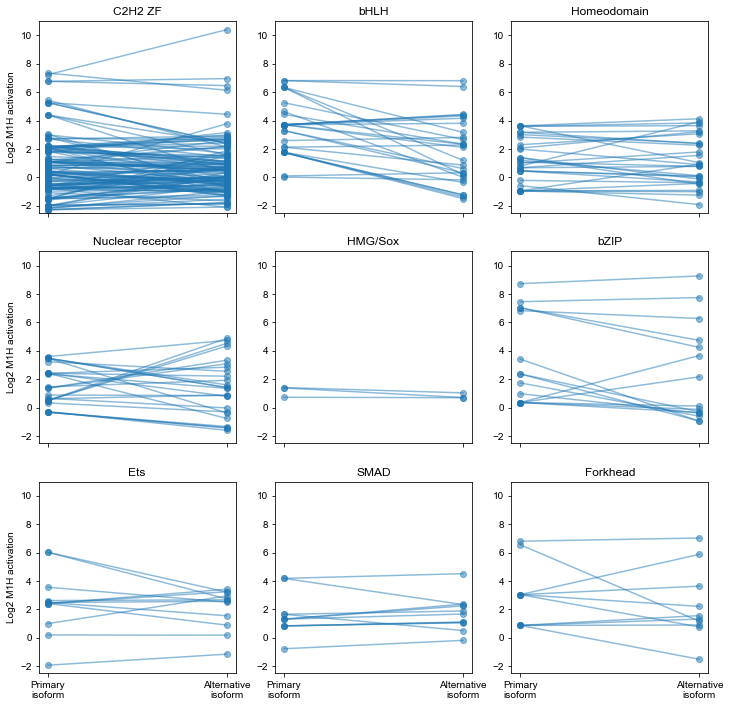

In [51]:
dbd_to_plot = df['DBD'].value_counts()[df['DBD'].value_counts() >= 10].index
if len(dbd_to_plot) != 9:
    raise UserWarning('Number of families above cutoff had changed')
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(4 * 3, 4 * 3)
for family, ax in zip(dbd_to_plot, axs.flatten()):
    for _i, row in df.loc[(df['DBD'] == family) & df['m1h_ref'].notnull() & df['m1h_alt'].notnull(), :].iterrows():
        ax.plot([0, 1], 
                [row['m1h_ref'], row['m1h_alt']],
                'o-',
                color='C0', alpha=0.5)
    ax.set_ylim(-2.5, 11)
    ax.set_xticks([0, 1])

    ax.set_title(family)
for ax in axs[:, 0]:
    ax.set_ylabel('Log2 M1H activation')
for ax in axs[:-1, :].flatten():
    ax.set_xticklabels(['', ''])
for ax in axs[-1, :]:
    ax.set_xticklabels(['Primary\nisoform', 'Alternative\nisoform'])
plt.savefig('../figures/m1h_by-DBD-family_pairplot.pdf',
            bbox_inches='tight')

In [96]:
m1h['DBD'] = m1h['gene'].map(tf_fam)

C2H2 ZF 3.999000153234811
bHLH 0.00010561707345773583
Homeodomain 0.008049158836107845
Nuclear receptor 0.0012159614958710285
HMG/Sox 0.07866767729230216
bZIP 0.002934300612440041
Ets 0.002022305729202092
SMAD 0.03771262026016983
Forkhead 0.006564991660407399


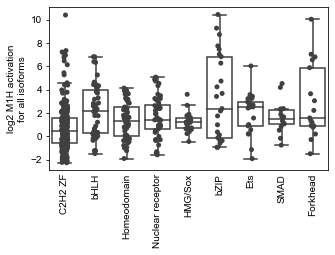

In [102]:
# m1h for all isoforms

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=m1h, x='DBD', y='mean', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=m1h, x='DBD', y='mean', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('log2 M1H activation\nfor all isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
for dbd in dbd_to_plot:
    print(dbd, stats.mannwhitneyu(m1h.loc[(m1h['DBD'] == 'C2H2 ZF') & m1h['mean'].notnull(), 'mean'].values,
                                  m1h.loc[(m1h['DBD'] == dbd) & m1h['mean'].notnull(), 'mean'].values)[1] * 8)

plt.savefig('../figures/M1H-all_isoforms_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

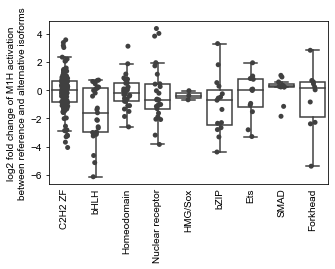

In [99]:
df['m1h_change'] = df['m1h_alt'] - df['m1h_ref']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='m1h_change', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='m1h_change', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)
plt.savefig('../figures/M1H-change_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

C2H2 ZF 3.9974273949832493
bHLH 0.05611515365520313
Homeodomain 2.1461700275604936
Nuclear receptor 0.02826252613665936
HMG/Sox 0.706914044908797
bZIP 0.06281889834983735
Ets 2.070729135196485
SMAD 1.8775282377455507
Forkhead 1.6369598665252392


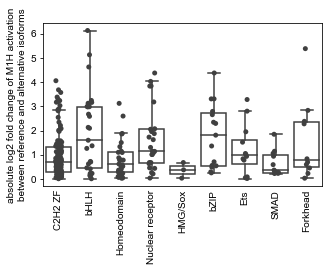

In [100]:
# absolute difference
df['m1h_abs_change'] = (df['m1h_alt'] - df['m1h_ref']).abs()
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='m1h_abs_change', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='m1h_abs_change', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('absolute log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
for dbd in dbd_to_plot:
    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/M1H-absolute-change_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

In [103]:
df['n_aa_diff'] = df.apply(lambda x: len(tfs[x['gene']][x['ref_iso']].aa_seq) - len(tfs[x['gene']][x['alt_iso']].aa_seq), axis=1)

In [110]:
(df['n_aa_diff'] < 1).sum()
# HACK
df['n_aa_diff'] = df['n_aa_diff'].abs()

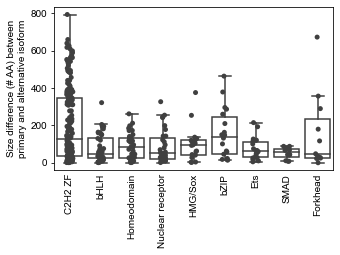

In [113]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='n_aa_diff', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='n_aa_diff', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('Size difference (# AA) between\nprimary and alternative isoform')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
#for dbd in dbd_to_plot:
#    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
#                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/n-AA-diff_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

In [114]:
df['pct_aa_diff'] = (df.apply(lambda x: (len(tfs[x['gene']][x['ref_iso']].aa_seq) - len(tfs[x['gene']][x['alt_iso']].aa_seq)) / len(tfs[x['gene']][x['ref_iso']].aa_seq), axis=1) * 100).abs()

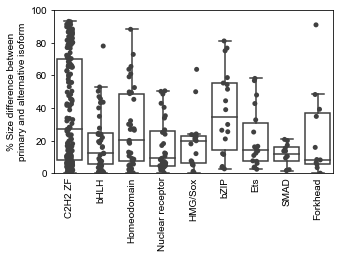

In [116]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='pct_aa_diff', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='pct_aa_diff', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('% Size difference between\nprimary and alternative isoform')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.set_ylim(0, 100)

# p-values
#for dbd in dbd_to_plot:
#    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
#                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/pct-AA-diff_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

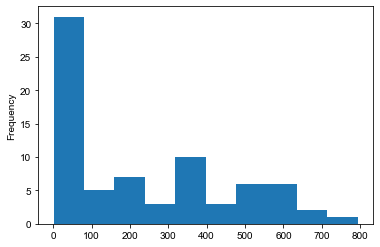

In [88]:
df['n_aa_diff'].plot.hist()

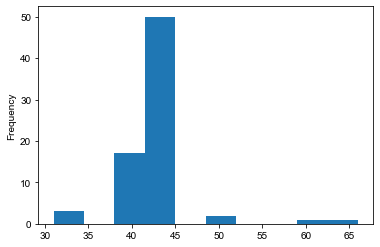

In [90]:
df['length'].plot.hist()

In [91]:
df.shape

(74, 13)

In [93]:
(df['n_aa_diff'] <= 100).sum()

32

MannwhitneyuResult(statistic=84.0, pvalue=0.18547551726654832)


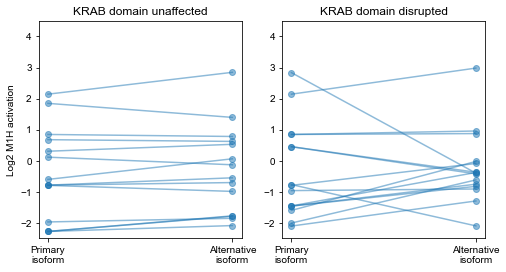

In [106]:
pair_plot(df.dropna().loc[df['n_aa_diff'] <= 100, :])
plt.savefig('../figures/KRAB-affected-M1H_less-than-100-aa-diff_pairplot.pdf',
            bbox_inches='tight')

In [116]:
df.to_csv('~/Desktop/M1H_KRAB_TFs.tsv', sep='\t', index=False)

In [107]:
# check overlap of KRAB PFam domain with manually annotated
doms = pd.read_excel('../data/internal/TF_reg_domain_2019-08-13.xlsx',
                   sheet_name='Sheet1')
doms = (doms.loc[:, ['symbol', 'Domain type', 'Domain sequence', 'aa position']]
        .rename(columns={'symbol': 'hgnc_gene_symbol',
                         'Domain type': 'type',
                         'Domain sequence': 'aa_seq',
                         'aa position': 'pos'}))
doms = doms.dropna()
doms['aa_seq'] = doms['aa_seq'].str.replace(' ', '')

In [112]:
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length,is_affected,complete_removal,m1h_ref,m1h_alt,n_aa_diff
0,ZFP1,ZFP1-1,ZFP1-2,PF01352,27,0,0,41,True,False,-2.005591,-0.617791,32
1,ZFP1,ZFP1-1,ZFP1-3,PF01352,0,0,0,41,False,False,-2.005591,0.077712,336
2,ZFP1,ZFP1-1,ZFP1-4,PF01352,41,0,0,41,True,True,-2.005591,0.339418,378
3,ZKSCAN1,ZKSCAN1-1,ZKSCAN1-2,PF01352,0,0,0,41,False,False,0.211933,-0.912573,177
4,ZKSCAN3,ZKSCAN3-1,ZKSCAN3-2,PF01352,0,0,0,41,False,False,1.062538,1.571580,119
